In [21]:
import numpy as np


class InputSet:
    def __init__(self, height, width, ):
        self.adder_features = np.zeros((height, width), dtype=bool)
        self.adder_time = None
        self.cv_features = np.zeros((height, width), dtype=bool)
        self.cv_time = None

    def total_adder(self):
        return np.sum(self.adder_features.astype(int))

    def total_cv(self):
        return np.sum(self.cv_features.astype(int))

In [22]:
def process_entry(entry, input_sets):
    if "OpenCV" in entry['s']:
        input_sets[-1].cv_features[entry['y'], entry['x']] = True
    elif "ADDER" in entry['s']:
        input_sets[-1].adder_features[entry['y'], entry['x']] = True
    else:
        raise Exception("Malformed entry")

In [23]:
import pickle

objects = []
with (open("/home/andrew/Code/adder-codec-rs/features_12_10_2023_16_18_26.log", "rb")) as openfile:
    # Read the dimensions
    dims = openfile.readline().decode('UTF-8')
    print(dims)
    width = int(dims.split('x')[0])
    height = int(dims.split('x')[1])
    #
    dbg_lines = 0
    #
    input_interval_idx = 0
    #
    input_sets = [InputSet(height, width)]

    while True:
        try:
            entry = pickle.load(openfile)
            if type(entry) == str and "ADDER FAST:" in entry:
                time = entry.split(': ')[1]
                input_sets[-1].adder_time = int(time)
                continue
            elif type(entry) == str and "OpenCV FAST:" in entry:
                time = entry.split(': ')[1]
                input_sets[-1].cv_time = int(time)
                input_sets += [InputSet(height, width)]
                input_interval_idx += 1
            else:
                process_entry(entry, input_sets)

                # print(entry)
                dbg_lines += 1
                # if dbg_lines == 100000:
                #     break
        except EOFError:
            break



640x360x1


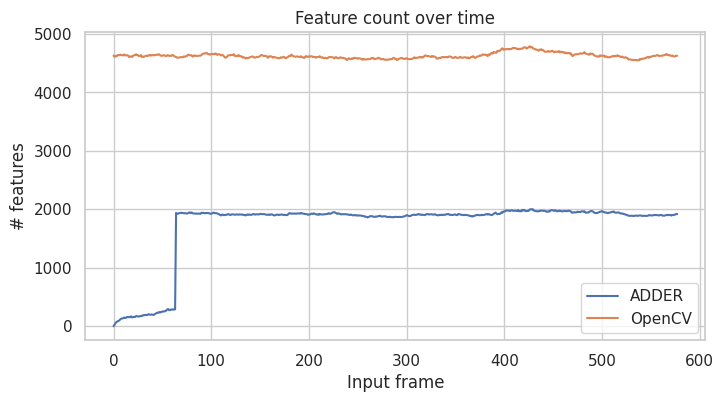

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import mpld3

adder_feature_count = [obj.total_adder() for obj in input_sets]
cv_feature_count = [obj.total_cv() for obj in input_sets]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))

sns.lineplot(x=range(len(input_sets) - 1), y=adder_feature_count[:-1], marker=None, label="ADDER")
sns.lineplot(x=range(len(input_sets) - 1), y=cv_feature_count[:-1], marker=None, label="OpenCV")
plt.ylabel("# features")
plt.xlabel("Input frame")
plt.title("Feature count over time")

plt.show()

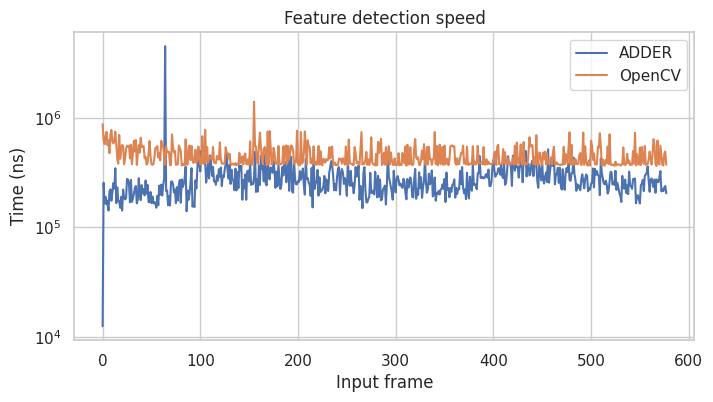

OpenCV mean: 455992.8339100346   Median: 414117.5
ADDER mean: 279317.75951557094 (-38.7%)   Median: 258931.5


In [26]:
adder_times = [obj.adder_time for obj in input_sets]
cv_times = [obj.cv_time for obj in input_sets]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))

sns.lineplot(x=range(len(input_sets)), y=adder_times, marker=None, label="ADDER")
sns.lineplot(x=range(len(input_sets)), y=cv_times, marker=None, label="OpenCV")
plt.ylabel("Time (ns)")
plt.xlabel("Input frame")
plt.yscale('log')
plt.title("Feature detection speed")

plt.show()
# interactive_plot = mpld3.display()
# interactive_plot


cv_mean = np.mean(np.array(cv_times[:-1]))
adder_mean = np.mean(np.array(adder_times[:-1]))
percent_change = (adder_mean / cv_mean) - 1
print('OpenCV mean:', cv_mean, '  Median:', np.median(np.array(cv_times[:-1])))
print('ADDER mean:', adder_mean, "({:.1f}%)".format(percent_change * 100), '  Median:',
      np.median(np.array(adder_times[:-1])))
